In [3]:
import scanpy as sc
from matplotlib import pyplot as plt
import scmulti

In [2]:
%load_ext autoreload
%autoreload 2

# Load the dataset

In [5]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40018
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## Shuffle data

In [13]:
from random import shuffle
from scipy import sparse
import anndata as ad

def shuffle_adata(adata):
    
    mapIndexPosition = list(zip(list(adata.obs_names), range(len(adata.obs_names))))
    shuffle(mapIndexPosition)
    obs_names, idx = zip(*mapIndexPosition)
    
    if sparse.issparse(adata.X):        
        x = adata.X.A[idx, :]
    else:
        x = adata.X[idx, :]
        
    adata.obs_names = adata.obs_names.astype(str).str.strip()
    adata.obs.loc[list(obs_names), :]
    
    return ad.AnnData(x, obs=adata.obs.loc[list(obs_names), :])

In [14]:
scrna = shuffle_adata(scrna)
cite = shuffle_adata(scatac)

# Configure and train the model

In [22]:
model = scmulti.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [1]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-1,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [23]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0
)

 |██------------------| 10.0% iter=1001/10000, time=273.22(s), loss=0.2740, recon=0.2603, kl=62.4394, integ=0.1306, val_loss=16.1569, val_recon=0.2157, val_kl=84.7022, val_integ=0.1105
 |████----------------| 20.0% iter=2001/10000, time=262.21(s), loss=0.2294, recon=0.2206, kl=122.2899, integ=0.0757, val_loss=15.7262, val_recon=0.2118, val_kl=121.9233, val_integ=0.0843
 |██████--------------| 30.0% iter=3001/10000, time=263.37(s), loss=0.2236, recon=0.2159, kl=136.5915, integ=0.0632, val_loss=15.5334, val_recon=0.2099, val_kl=125.7466, val_integ=0.0762
 |████████------------| 40.0% iter=4001/10000, time=266.48(s), loss=0.2197, recon=0.2129, kl=125.9734, integ=0.0558, val_loss=15.3869, val_recon=0.2086, val_kl=111.0132, val_integ=0.0700
 |██████████----------| 50.0% iter=5001/10000, time=262.04(s), loss=0.2183, recon=0.2119, kl=111.7291, integ=0.0530, val_loss=15.2564, val_recon=0.2073, val_kl=95.1945, val_integ=0.0653
 |████████████--------| 60.0% iter=6001/10000, time=265.16(s), loss=

## Plot training history

In [24]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,val_loss,val_recon,val_kl,val_integ
0,1000,0.274020,0.260332,62.439415,0.130637,16.156880,0.215688,84.702225,0.110461
1,2000,0.229428,0.220640,122.289908,0.075652,15.726204,0.211799,121.923329,0.084290
2,3000,0.223612,0.215924,136.591476,0.063225,15.533444,0.209862,125.746620,0.076229
3,4000,0.219715,0.212874,125.973375,0.055810,15.386930,0.208559,111.013215,0.069975
4,5000,0.218300,0.211884,111.729123,0.052980,15.256377,0.207324,95.194502,0.065348
5,6000,0.218581,0.212643,98.841507,0.049493,15.192083,0.206873,85.734597,0.061713
6,7000,0.217475,0.211678,92.188327,0.048743,15.112611,0.206226,80.384371,0.057508
7,8000,0.216288,0.210885,85.130775,0.045521,15.084007,0.206049,76.065187,0.055641
8,9000,0.216792,0.210892,81.785034,0.050817,15.048665,0.205719,74.779747,0.054133
9,9999,0.216292,0.211034,80.469566,0.044540,15.007120,0.205468,75.061011,0.050811


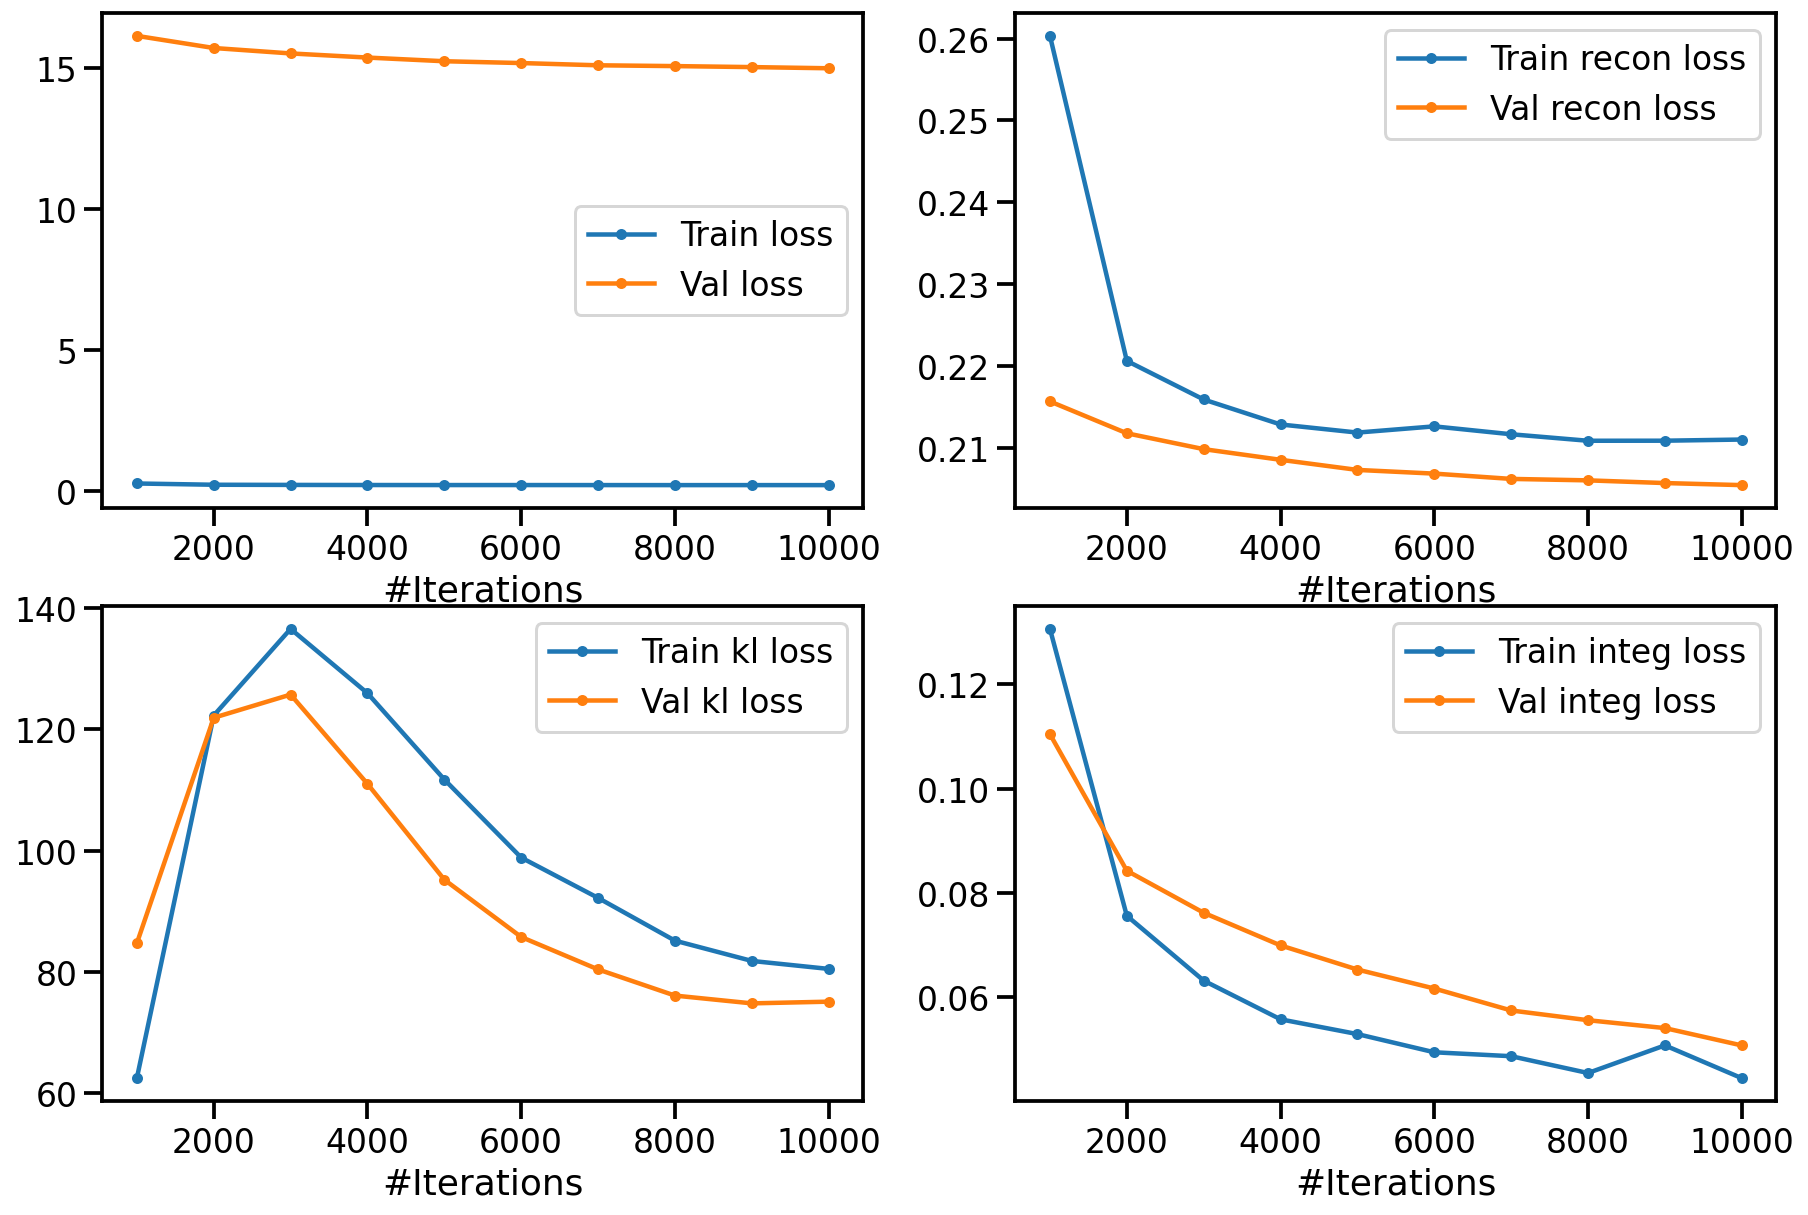

In [25]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

# Validation

In [26]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 20000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [27]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


... storing 'modality' as categorical
... storing 'cell_type' as categorical


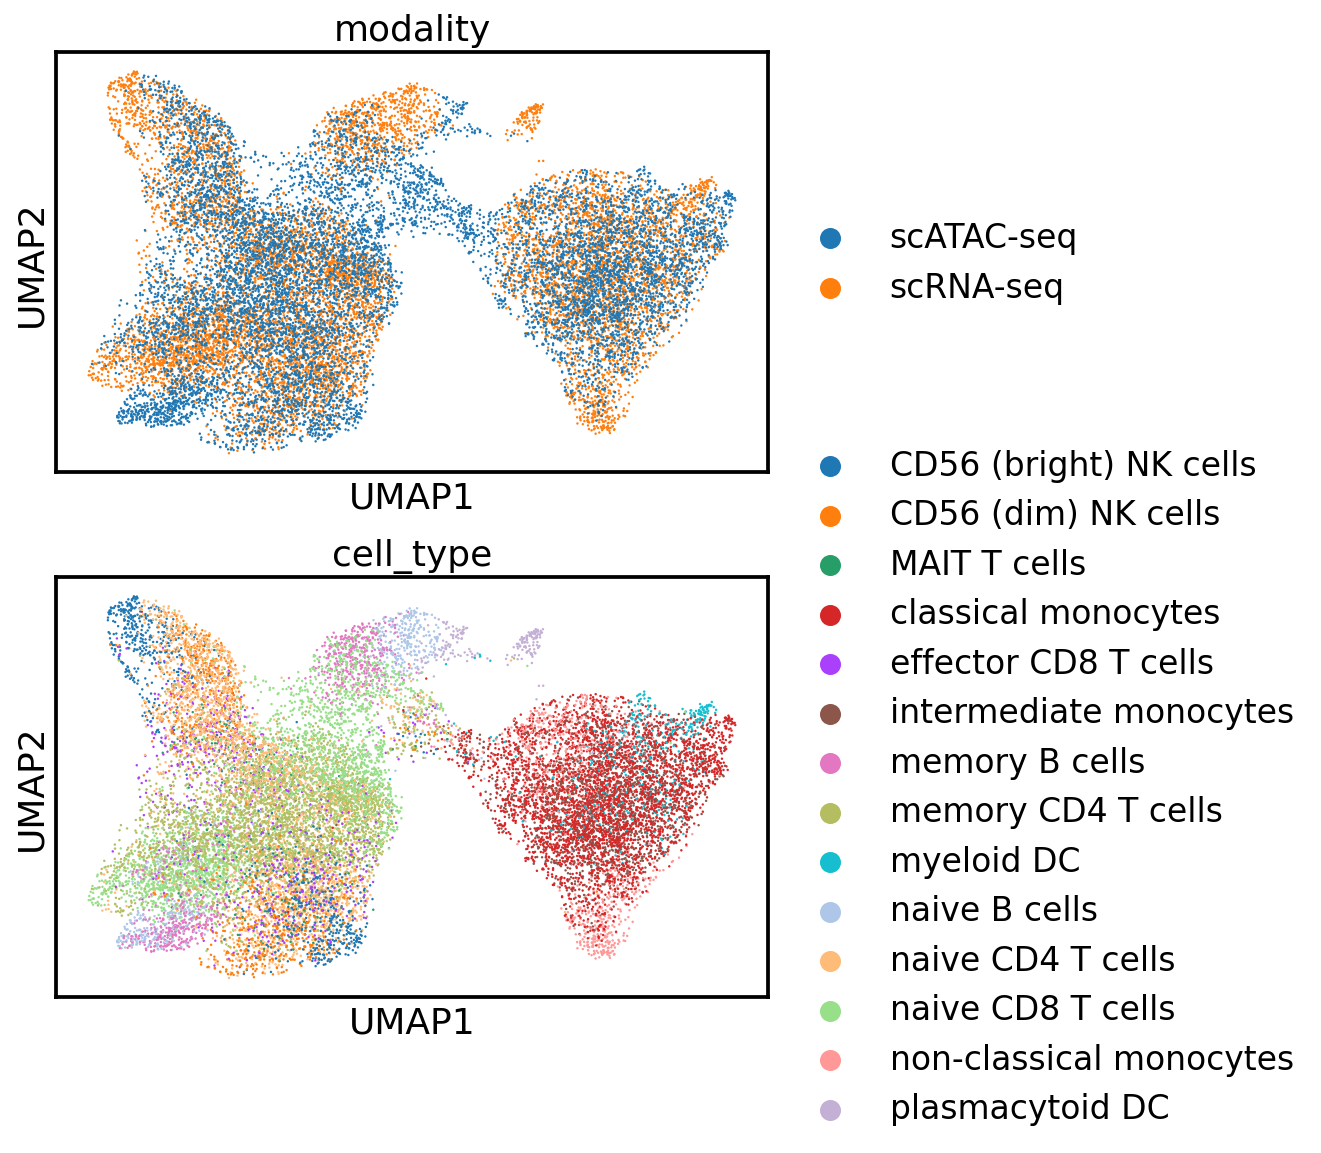

In [28]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

In [23]:
scmulti.metrics.nmi(z, label_key='modality')

0.0007519537623257798

In [24]:
scmulti.metrics.asw(z, label_key='modality')

0.007808674592524767

In [25]:
scmulti.metrics.asw(z, label_key='cell_type')

0.10626163333654404

In [26]:
sc.pp.pca(z)
metrics = scmulti.metrics.scibmetrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/home/aomidi/.conda/envs/scanpy/lib/python3.7/sit

NMI...
ARI...
silhouette score...


/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/scanpy/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi

,0
NMI_cluster/label,0.670802
ARI_cluster/label,0.503553
ASW_label,0.553201
ASW_label/batch,0.917820
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN
